# Example notebook

In [1]:
%matplotlib inline
from skimage import transform
import numpy as np
import logging
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import ImageLoader, FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from floortrans.metrics import get_evaluation_tensors, runningScore
from tqdm import tqdm

from mpl_toolkits.axes_grid1 import AxesGrid
from IPython.display import Image
from IPython.core.display import HTML 

rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

data_folder = 'data/cubicasa5k/'
data_file = 'test.txt'
normal_set = ImageLoader(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)


/home/user/floorplan/floortrans/plotting.py:611: UserWarning: Overwriting the cmap 'rooms_furu' that was already in the registry.
  cm.register_cmap(cmap=cmap3, override_builtin=True)


In [2]:
# Setup Model
model = get_model('hg_furukawa_original', 51)
n_classes = 44
n_icons = len(icon_classes)
n_rooms = len(room_classes)
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()
print("Model loaded.")

Model loaded.


In [3]:
# Logger
logger = logging.getLogger('eval')
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('runs_cubi/'+'eval.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

  0%|                                                     | 0/4 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


FileNotFoundError: [Errno 2] No such file or directory: 'data/output/1740.svg'

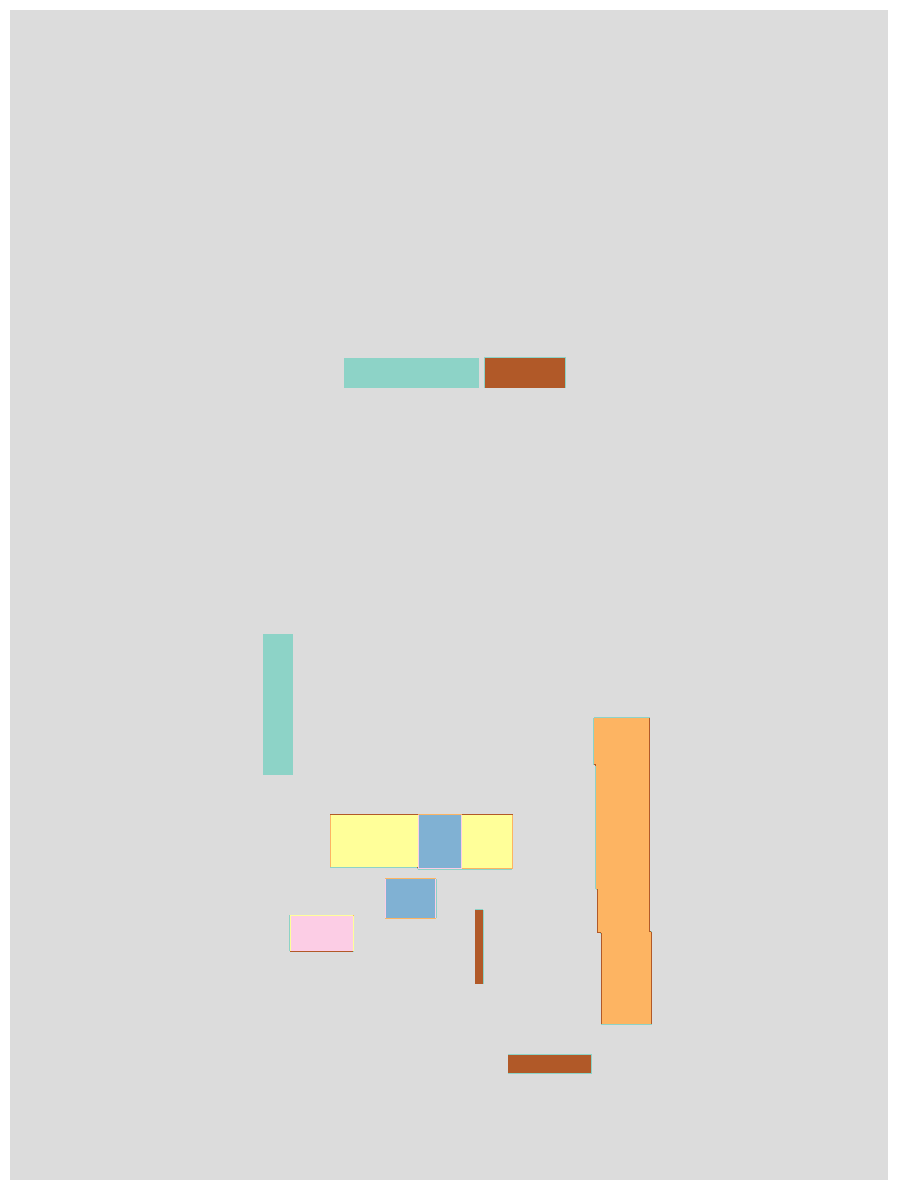

In [13]:
# Predict
with torch.no_grad():
  # Rotation vars
  rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
  pred_count = len(rotations)

  for count, val in tqdm(enumerate(data_loader), total=len(data_loader),
                          ncols=80, leave=False):
    logger.info(count)
    item_id = val['item_id'][0]
    folder = val['folder'][0]
    image = val['image']
    images_val = val['image'].cuda()
    height = val['height']
    width = val['width']

    image_np = image.data.numpy()[0]
    img_size = (height, width)
    
    rot = RotateNTurns()
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
      forward, back = r
      # We rotate first the image
      rot_image = rot(images_val, 'tensor', forward)
      pred = model(rot_image)
      # We rotate prediction back
      pred = rot(pred, 'tensor', back)
      # We fix heatmaps
      pred = rot(pred, 'points', back)
      # We make sure the size is correct
      pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
      # We add the prediction to output
      prediction[i] = pred[0]

    prediction = torch.mean(prediction, 0, True)

    rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
    rooms_pred = np.argmax(rooms_pred, axis=0)

    icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
    icons_pred = np.argmax(icons_pred, axis=0)

    # Post-processing
    heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
    polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

    pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons,  room_types, height, width)
    plt.figure(figsize=(12,12))
    ax = plt.subplot(1, 1, 1)
    ax.axis('off')
    rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
    iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
    # cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
    # cbar.ax.set_yticklabels(room_classes, fontsize=20)
    plt.tight_layout()
    # plt.savefig(f'{folder}/output.svg', format="svg")
    plt.savefig(os.path.join('/data', 'output', '%s.svg' % (item_id,))) 